In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Barnstable and Long-Run Risk

## HBS Case

### *The Risk of Stocks in the Long-Run: The Barnstable College Endowment*

***

# 1. READING - Barnstable

### 1 Barnstable's Philosophy

* What has Barnstable's investment strategy been in the past?
* Explain the logic behind their view that stocks are safer in the long run.
* What assumptions underlie Barnstable's belief in the long-run safety of stocks?

### 2. Two proposals

Describe the two proposals Barnstable is considering for how to take advantage of their view regarding the long-run safety of stocks.

### 3. The trust
How is the trust different from simply shorting the risk-free rate to take a levered position in stocks?

### 4. Payoff differences

*You may not have had a course in options. It's okay if you are only vaguely familiar with the mechanics below and the option payoffs.*

Do these proposals take the same bet on long-run stock performance? In what outcomes will they have different returns?

The payoff at maturity of the common share is:

$$\Gamma_{30}^{\text{common}} = \max\left(\texttt{r}^m_{t,t+30} - \exp\left\{.06(30)\right\},~ 0\right)$$

The payoff at maturity of selling puts is:

$$\Gamma_{30}^{\text{selling puts}} = - \max\left(\exp\left\{.06(30)\right\} - \texttt{r}^m_{t,t+30}, 0\right)$$

### 5. Risk differences
Do the two proposals differ in their risk?

### 6. Recommendation
Do you recommend a direct investment in the S&P, the trust or the puts?

# 2. Estimating Underperformance

### Data

Use the returns on the S&P 500 ($r^m$) and 1-month T-bills, ($r^f$) provided in `barnstable_analysis_data.xlsx`.
* Data goes through `END_YR=2024`.

Barnstable's estimates of mean and volatility are based on the subsample of 1965 to 1999.
* We consider this subsample, as well as 2000-{END_YR}, as well as the full sample of 1926-{END_YR}.

In [2]:
file = "data/barnstable_analysis_data.xlsx"


df = pd.read_excel(file, sheet_name="data",index_col=0)
r_m = df["SPX"]
r_f = df["TB1M"]

### Notation

* $r$ = level return rates
* $R$ = cumulative return factor
* $\texttt{r}$ = log return rates

$$ R \equiv 1+r$$

$$ \texttt{r} \equiv \ln(1+r) = \ln(R)$$

### 1. Summary Statistics

Report the following (annualized) statistics.

| | 1965-1999 | | | 2000-{END_YR} | | | 1926-{END_YR} | |
|---|---|---|---|---|---|---|---|---|
| | mean | vol | | mean | vol | | mean | vol |
| **levels** | $r^m$ | | | | | | | |
| | $\tilde{r}^m$ | | | | | | | |
| | $r^f$ | | | | | | | |
| **logs** | $\texttt{r}^m$ | | | | | | | |
| | $\tilde{\texttt{r}}^m$ | | | | | | | |
| | $\texttt{r}_f$ | | | | | | | |

* Comment on how the full-sample return stats compare to the sub-sample stats.
* Comment on how the level stats compare to the log stats.

In [4]:
df_index = pd.to_datetime(df.index)

df_65_99 = df.loc['1965-01-01':'1999-12-31']
df_00_end = df.loc['2000-01-01':'2024-12-31']
df_26_end = df.loc['1926-01-01':'2024-12-31']


df['r_m_tilde'] = r_m - r_f

def annualized_stats(series):
    mean = series.mean() * 12
    vol = series.std(ddof=1) * np.sqrt(12)
    return mean, vol

def log_annualized_stats(series):
    log_series = np.log(series + 1)
    mean = log_series.mean() * 12
    vol = log_series.std(ddof=1) * np.sqrt(12)
    return mean, vol

for label, subset in {
    "1965–1999": df_65_99,
    "2000–END": df_00_end,
    "1926–END": df_26_end,
}.items():
    print(label)
    for col in ['SPX', 'r_m_tilde', 'TB1M']:
        mean, vol = annualized_stats(subset[col])
        print(f"  {col:10s} mean={mean:.4f}, vol={vol:.4f}")
    print("Log returns")
    for col in ['SPX', 'r_m_tilde', 'TB1M']:
        mean, vol = log_annualized_stats(subset[col])
        print(f"  {col:10s} mean={mean:.4f}, vol={vol:.4f}")



1965–1999
  SPX        mean=0.1294, vol=0.1494
  r_m_tilde  mean=0.0687, vol=0.1502
  TB1M       mean=0.0615, vol=0.0072
Log returns
  SPX        mean=0.1176, vol=0.1496
  r_m_tilde  mean=0.0572, vol=0.1512
  TB1M       mean=0.0613, vol=0.0071
2000–END
  SPX        mean=0.0875, vol=0.1528
  r_m_tilde  mean=0.0701, vol=0.1531
  TB1M       mean=0.0175, vol=0.0056
Log returns
  SPX        mean=0.0756, vol=0.1538
  r_m_tilde  mean=0.0581, vol=0.1542
  TB1M       mean=0.0174, vol=0.0055
1926–END
  SPX        mean=0.1155, vol=0.1866
  r_m_tilde  mean=0.0833, vol=0.1873
  TB1M       mean=0.0319, vol=0.0085
Log returns
  SPX        mean=0.0978, vol=0.1859
  r_m_tilde  mean=0.0657, vol=0.1869
  TB1M       mean=0.0318, vol=0.0085


The 1965–1999 subsample exhibits the highest nominal market mean return (~12.9%) and a moderate volatility (~15%), producing a strong equity premium relative to the 1-month T-bill. Post-2000 returns fall substantially in mean but retain similar volatility, reflecting the weaker post-dot-com and post-GFC growth environment.
Across all periods, log-return means are consistently 1–2 percentage points lower than level means, while volatilities remain virtually unchanged.
Overall, the full-sample (1926–END) statistics smooth cyclical extremes, yielding long-term Sharpe ratios near 0.45 – 0.50.

### 2. Probability of Underperformance

Recall the following:
- If $x\sim\mathcal{N}\left(\mu_x,\sigma_x^2\right)$, then

  $$\Pr\left[x<\ell\right] = \Phi_\mathcal{N}\left(L\right)$$

  where $L = \frac{\ell-\mu_x}{\sigma_x}$ and $\Phi_\mathcal{N}$ denotes the standard normal cdf.

- Remember that cumulative log returns are simply the sum of the single-period log returns:
  
  $$\texttt{r}^m_{t,t+h} \equiv \sum_{i=1}^h \texttt{r}^m_{t+i}$$

- It will be convenient to use and denote sample averages. We use the following notation for an $h$-period average ending at time $t+h$:
  
  $$\bar{\texttt{r}}^m_{t,t+h} = \frac{1}{h}\sum_{i=1}^h \texttt{r}^m_{t+i}$$

Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return:

$$\Pr\left[R^m_{t,t+h} < R^f_{t,t+h}\right]$$

To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.

#### 2.1
Calculate the probability using the subsample 1965-1999.

#### 2.2
Report the precise probability for $h=15$ and $h=30$ years.

#### 2.3
Plot the probability as a function of the investment horizon, $h$, for $0<h\le 30$ years.

**Hint**: The probability can be expressed as:

$$p(h) = \Phi_{\mathcal{N}}\left(-\sqrt{h}\;\text{SR}\right)$$

where $\text{SR}$ denotes the sample Sharpe ratio of **log** market returns.

In [5]:
#2.1

df_65_99 = df.loc['1965-01-01':'1999-12-31'].copy()

df_65_99["log_excess"] = np.log(1 + df_65_99["SPX"]) - np.log(1 + df_65_99["TB1M"])

SR = df_65_99["log_excess"].mean() / df_65_99["log_excess"].std(ddof=1) * np.sqrt(12)
print(f"Sample Sharpe Ratio (1965–1999, log excess returns): {SR:.4f}")


Sample Sharpe Ratio (1965–1999, log excess returns): 0.3794


In [6]:
#2.2
# Define probability function p(h)
def p_underperformance(h, SR):
    return norm.cdf(-np.sqrt(h) * SR)

for h in [15, 30]:
    prob = p_underperformance(h, SR)
    print(f"Probability of market underperforming risk-free over {h} years: {prob:.4%}")

Probability of market underperforming risk-free over 15 years: 7.0848%
Probability of market underperforming risk-free over 30 years: 1.8846%


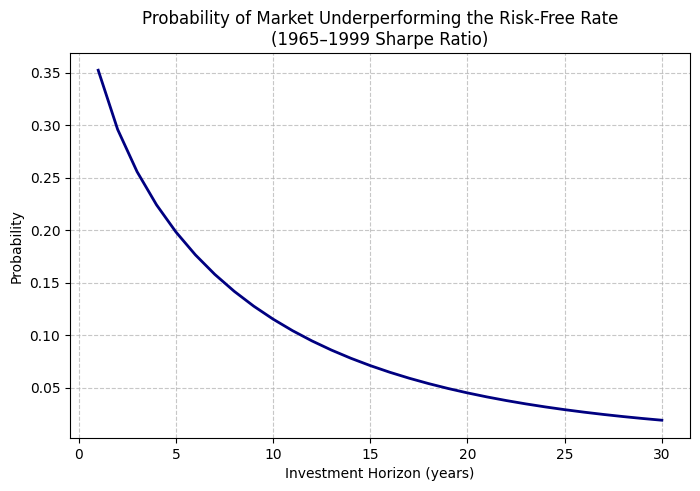

In [7]:
# 2.3

horizons = np.arange(1, 31)
probs = [p_underperformance(h, SR) for h in horizons]

plt.figure(figsize=(8,5))
plt.plot(horizons, probs, lw=2, color='navy')
plt.title("Probability of Market Underperforming the Risk-Free Rate\n(1965–1999 Sharpe Ratio)", fontsize=12)
plt.xlabel("Investment Horizon (years)")
plt.ylabel("Probability")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

### 3. Full Sample Analysis

Use the sample 1965-{END_YR} to reconsider the 30-year probability. As of the end of {END_YR}, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, $R^m_{t,t+h}$ underperforming $R^f_{t,t+h}$ for $0<h\le 30$.

In [8]:
# Calculate Sharpe ratio for full sample (1965–2024)
df_65_24 = df.loc['1965-01-01':'2024-12-31'].copy()
df_65_24["log_excess"] = np.log(1 + df_65_24["SPX"]) - np.log(1 + df_65_24["TB1M"])
SR = df_65_24["log_excess"].mean() / df_65_24["log_excess"].std(ddof=1) * np.sqrt(12)

# Compute 30-year underperformance probability
#prob_30_full = underperformance_probability(30, SR_full)
print(f"Sharpe Ratio (1965–2024): {SR:.4f}")

for h in [30]:
    prob = p_underperformance(h, SR)
    print(f"Probability of market underperforming risk-free over {h} years: {prob:.4%}")

Sharpe Ratio (1965–2024): 0.3788
Probability of market underperforming risk-free over 30 years: 1.9002%


### 4. In-Sample Estimate of Out-of-Sample Likelihood

Let's consider how things turned out relative to Barnstable's 1999 expectations.

What was the probability (based on the 1999 estimate of $\mu$) that the `h`-year market return, $R^m_{t,t+h}$, would be smaller than that realized in `2000-{END_YR}`? 

**Hint**: You can calculate this as:

$$p = \Phi_{\mathcal{N}}\left(\sqrt{h}\; \frac{\bar{\texttt{r}}_{out-of-sample} - \bar{\texttt{r}}_{\text{in-sample}}}{\sigma_{\text{in-sample}}}\right)$$

where "in-sample" denotes 1965-1999 and "out-of-sample" denotes 2000-{END_YR}.

In [13]:
mu_in = df_65_99["log_excess"].mean() * 12
sigma_in = df_65_99["log_excess"].std(ddof=1) * np.sqrt(12)

df_00_end = df_00_end.copy()
df_00_end["log_excess"] = np.log1p(df_00_end["SPX"]) - np.log1p(df_00_end["TB1M"])
mu_out = df_00_end["log_excess"].mean() * 12

h = len(df_00_end) / 12

z = np.sqrt(h) * (mu_out - mu_in) / sigma_in
p = norm.cdf(z)

print(f"In-sample mean = {mu_in:.4f}, vol = {sigma_in:.4f}")
print(f"Out-of-sample mean = {mu_out:.4f}")
print(f"h = {h:.1f} years, z = {z:.3f}, p = {p:.4%}")

In-sample mean = 0.0571, vol = 0.1504
Out-of-sample mean = 0.0581
h = 25.0 years, z = 0.035, p = 51.4128%
